# Variational inference using the finite approximation

trying standard cavi

In [10]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [11]:
np.random.seed(43141) 
Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)


In [12]:
"""np.random.seed(43141) 

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?
A = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))
print(A)

# draw noise
# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)
epsilon = np.random.normal(0, sigma_eps, (Num_samples, D))

# the observed data
X = np.dot(Z,A) + epsilon
"""

"np.random.seed(43141) \n\nNum_samples = 500 # sample size\nD = 2 # dimension\n# so X will be a N\times D matrix\n\nK_inf = 3 # take to be large for a good approximation to the IBP\n\n\nalpha = 10 # IBP parameter\nPi = np.ones(K_inf) * .8\nZ = np.zeros([Num_samples,K_inf])\n\n# Parameters to draw A from MVN\nmu = np.zeros(D)\nsigma_A = 100\n\nsigma_eps = .1 # variance of noise\n\n# Draw Z from truncated stick breaking process\nfor k in range(K_inf):\n    # Pi[k] = np.random.beta(alpha/K_inf,1)\n    for n in range(Num_samples):\n        Z[n,k] = np.random.binomial(1,Pi[k])\n\n        \nprint('true Z (first 10 rows): \n', Z[0:10,:])\n\n# Draw A from multivariate normal\n# A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf) # FOR SOME REASONG THIS KILLS THE KERNEL!?\nA = np.random.normal(0, np.sqrt(sigma_A), (K_inf, D))\nprint(A)\n\n# draw noise\n# epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)\nepsilon = np.random.normal(0, si

# set initializations

In [13]:
# set initializations
K_approx = deepcopy(K_inf) # variational truncation
tau, nu, phi_mu, phi_var = initialize_parameters(Num_samples, D, K_approx)

Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}

iterations = 1000
elbo = np.zeros(iterations)


In [14]:
"""K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': 100, 'A': sigma_A}
"""

"K_approx = deepcopy(K_inf) # variational truncation\n\ntau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v\n#tau = np.ones([K_approx,2])*1000\n#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi\n\n#nu = np.ones([Num_samples, K_approx]) *0.0\nnu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk\n#nu = deepcopy(Z)\n\nphi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column\n#phi_mu = deepcopy(A).T\nphi_var = np.ones(K_approx)\n\nnu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)\n\niterations = 1000\nelbo = np.zeros(iterations)\nelbo_Term1 = np.zeros(iterations)\nelbo_Term2 = np.zeros(iterations)\nelbo_Term3 = np.zeros(iterations)\nelbo_Term4 = np.zeros(iterations)\nelbo_Term5 = np.zeros(iterations)\nelbo_Term6 = np.zeros(iterations)\nelbo_Term7 = np.zeros(iterations)\n\n\nData_shape = {'D':D, 'N': Num_samples , 'K':K_approx}\nsigmas = {'eps': 100, 'A': sigma_A}\n"

In [15]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

# run CAVI

In [16]:
 
for i in range(iterations):
    iter_ran = i + 1

    cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)

    round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

    #[elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],elbo_Term7[i]] \
    #    = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)
    elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)[0]

    print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), 'elbo: ', elbo[i])
    #print(round_nu[0:10,:])

    if np.isnan(elbo[i]):
        print('NAN ELBO.')
        break

    if (i>0) & (elbo[i] < elbo[i-1]): 
        print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
        break

    if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8):
        print('ELBO converged')
        break
    

iteration:  0  l1 error:  0.361851869405 elbo:  -39650.7714797
iteration:  1  l1 error:  0.334139741237 elbo:  -22531.7485662
iteration:  2  l1 error:  0.324240063381 elbo:  -17847.7352176
iteration:  3  l1 error:  0.323333362922 elbo:  -14729.532844
iteration:  4  l1 error:  0.323333644756 elbo:  -12803.3394369
iteration:  5  l1 error:  0.323358382341 elbo:  -11642.8801805
iteration:  6  l1 error:  0.327254555908 elbo:  -10705.2123013
iteration:  7  l1 error:  0.331999623648 elbo:  -9808.53656567
iteration:  8  l1 error:  0.328691949264 elbo:  -9228.85970352
iteration:  9  l1 error:  0.32345227338 elbo:  -8615.44219531
iteration:  10  l1 error:  0.323333333334 elbo:  -8240.39932198
iteration:  11  l1 error:  0.323333333333 elbo:  -8013.84844863
iteration:  12  l1 error:  0.323333333333 elbo:  -7880.07551573
iteration:  13  l1 error:  0.323333333333 elbo:  -7801.48311807
iteration:  14  l1 error:  0.323333333333 elbo:  -7755.34243542
iteration:  15  l1 error:  0.323333333333 elbo:  -77

Z (unpermuted): 
 [[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [0, 1, 2]
Z (permuted) 
 [[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]]
round_nu 
 [[ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]]
l1 error (after permutation):  [0.85200000000006049, 1.0648923931879182e-139, 0.11799999999999999]


true A (permuted): 
 [[-3.07199514  5.0220693 ]
 [ 9.54417571  3.59640607]
 [ 1.1894611  -8.60276614]]
phi_mu: 
 [[ 0.64148571 -4.36579453]
 [ 6.82878259  8.53153398]
 [ 1.27289267 -8.62157685]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.27230668  0.81956378  0.68076669]


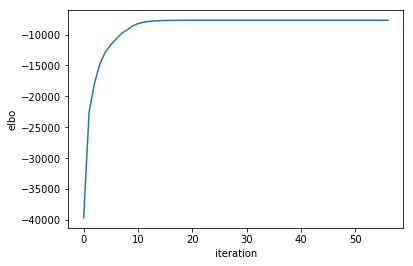

In [18]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [0,1,2]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

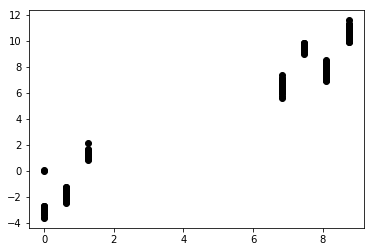

In [20]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 0
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

In [109]:
# let us permute the columms of nu and then compare: 
nu_perm = nu[:, (1,2,0)]
round_nu_perm = np.round(nu_perm*(nu_perm>=0.9) + nu_perm*(nu_perm<=0.1)) + nu_perm*(nu_perm>=0.1)*(nu_perm<=0.9)

print(np.sum(np.abs(Z[:,0] - nu_perm[:,0]))/Num_samples)
print(np.sum(np.abs(Z[:,1] - nu_perm[:,1]))/Num_samples)
print(np.sum(np.abs(Z[:,2] - nu_perm[:,2]))/Num_samples)

# so two of the rows are really close ...

0.9566
0.1538
0.706
